In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tqdm
import torch
import random
import pandas as pd

from vae.model import VAE
from vae.misc import LogPlotter
from vae.config import get_config
from vae.trainer import VAETrainer
from mnist4molecules.corpus import PandasDataset, OneHotCorpus
from mnist4molecules.metrics import diversity, validity, uniqueness

In [3]:
!nvidia-smi

Fri Jun 22 21:53:49 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
| 30%   59C    P2    59W / 250W |   8017MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:0A:00.0 Off |                  N/A |
| 51%   71C    P5    26W / 250W |     19MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [4]:
config = get_config()
config.lr_n_period, config.kl_start = 1, 0  # To test
config.device_code = 1
config

Namespace(d_cell='gru', d_dropout=0.0, d_n_layers=1, d_z=64, device_code=1, freeze_embeddings=False, grad_clipping=10, kl_start=0, kl_w_end=0.1, kl_w_start=0.01, lr_end=0.001, lr_n_mult=1, lr_n_period=1, lr_n_restarts=1, lr_start=0.01, n_batch=32, n_last=1000, n_len=100, q_bidir=True, q_cell='gru', q_d_h=64, q_dropout=0.0, q_n_layers=1, save_path='vae.pt')

In [5]:
device = torch.device(
    f'cuda:{config.device_code}' 
    if config.device_code >= 0 and torch.cuda.is_available() 
    else 'cpu'
)
torch.cuda.set_device(config.device_code)  # For CUDNN to work
device

device(type='cuda', index=1)

In [6]:
data_path = '/media/Molecules/molecules.csv'
n_train, n_val = 1_000_00, 100_00

%time data = pd.read_csv(data_path, usecols=['SMILES'])
data = data.sample(n_train + n_val)

train, val = data[:n_train], data[n_train: n_train + n_val]
train, val = PandasDataset(train), PandasDataset(val)
len(train), len(val)

CPU times: user 13.6 s, sys: 832 ms, total: 14.4 s
Wall time: 14.4 s


(100000, 10000)

In [7]:
corpus = OneHotCorpus(config.n_batch, device)
train = corpus.fit_transform(train)
# val = corpus.transform(val)
ds_val = val  # dataset

Fitting corpus with vocab: 100%|██████████| 100000/100000 [00:01<00:00, 73714.26it/s]


In [8]:
model = VAE(corpus.vocab, config).to(device)
trainer = VAETrainer(config) 
model

VAE(
  (x_emb): Embedding(34, 34, padding_idx=24)
  (encoder_rnn): GRU(34, 64, batch_first=True, bidirectional=True)
  (q_mu): Linear(in_features=128, out_features=64, bias=True)
  (q_logvar): Linear(in_features=128, out_features=64, bias=True)
  (decoder_rnn): GRU(98, 64, batch_first=True)
  (decoder_fc): Linear(in_features=64, out_features=34, bias=True)
  (encoder): ModuleList(
    (0): GRU(34, 64, batch_first=True, bidirectional=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): ModuleList(
    (0): GRU(98, 64, batch_first=True)
    (1): Linear(in_features=64, out_features=34, bias=True)
  )
  (vae): ModuleList(
    (0): Embedding(34, 34, padding_idx=24)
    (1): ModuleList(
      (0): GRU(34, 64, batch_first=True, bidirectional=True)
      (1): Linear(in_features=128, out_features=64, bias=True)
      (2): Linear(in_features=128, out_features=64, bias=True)
    )
    (2): ModuleList(
    

In [9]:
# Sanity check
x = next(iter(train))
kl_loss, recon_loss = model(x)
sampled_x = corpus.reverse(trainer.sample(model, 1))[0]
print(f"kl_loss={kl_loss:.2f} recon_loss={recon_loss:.2f}\nsampled_x='{sampled_x}'")

kl_loss=0.22 recon_loss=3.60
sampled_x='1c1Brs-[1'


In [10]:
elog, ilog = trainer.fit(model, train, corpus)

100%|██████████| 1/1 [01:33<00:00, 93.69s/it, i=3124/3125 loss=0.90115 (kl=2.99499 recon=0.87120) klw=0.01 lr=0.01000]

[epoch=0]: 'CC[NH+]1CC[NH+](C)C(C)(C)OC)c1'


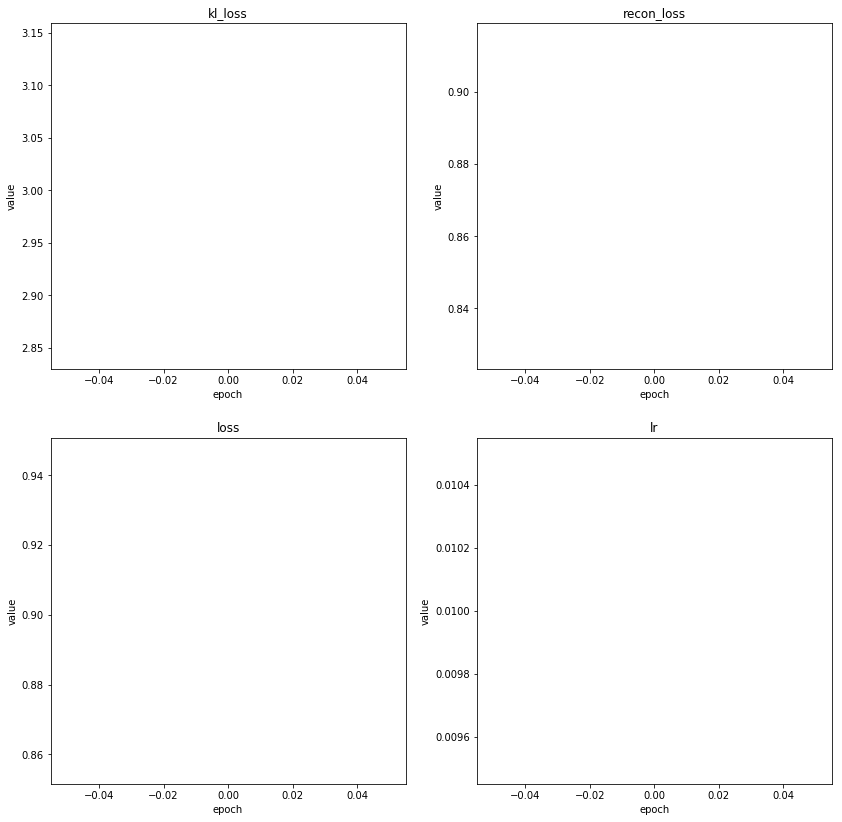

In [11]:
plotter = LogPlotter(elog)
plotter.grid([
    'kl_loss', 'recon_loss',
    'loss', 'lr'
])

In [12]:
# Same as Oktai
def test_model(dataset, n_gen=1000, n_other=1000):
    gen_smiles = []
    for _ in tqdm.tqdm_notebook(range(n_gen // 100)):  # hack
        gen_smiles.extend(corpus.reverse(trainer.sample(model, 100)))
        
    other_smiles = random.sample(list(dataset), n_other)

    internal_diversity_val = diversity(gen_smiles)
    external_diversity_val = diversity(gen_smiles, other_smiles)  # TODO: check it
    validity_val = validity(gen_smiles)
    uniqueness_val = uniqueness(gen_smiles)

    print('\n###########################')
    print('Internal Diversity = {}'.format(internal_diversity_val))
    print('External Diversity = {}'.format(external_diversity_val))
    print('Validity = {}'.format(validity_val))
    print('Uniqueness = {}'.format(uniqueness_val))
    print('############################\n')

In [13]:
test_model(ds_val)



###########################
Internal Diversity = 0.031227188890009607
External Diversity = 0.04868830638904869
Validity = 0.108
Uniqueness = 1.0
############################



In [14]:
torch.save(model, config.save_path)
!du -sh {path.save}

du: cannot access '{path.save}': No such file or directory
